In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime

In [2]:
def gillespieSEIHR(initial, beta, mu1,mu2, sigma, omega, alpha, epsilon, mort,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]+pop[ind][3]>0):
        state = np.zeros(shape= (5,12))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]

        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        
        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
#         total_inf = sum(cuminf)
        if event == 1:
            cuminf.append(1 + cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])
    return event_time, np.array(pop), events, cuminf

In [3]:
β = 0.005
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]
Nn = sum(Input_H)

In [48]:

Gh = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, α, ϵ, pp, capT)
SEIHRt = Gh[0]
SEIHRs = Gh[1][:,0]
SEIHRe = Gh[1][:,1]
SEIHRi = Gh[1][:,2]
SEIHRh = Gh[1][:,3]
SEIHRr = Gh[1][:,4]
# Gh[3]

In [53]:
sum(np.array(Gh[2])==1)

14

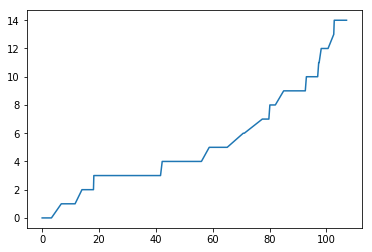

In [50]:
plt.plot(SEIHRt, Gh[3])

In [51]:
manhe = []
manht = []
manhh = []
manhi = []
cuminf = []
for ind, x in enumerate(SEIHRt):
    if ind<len(SEIHRt)-1:
        manhe.append((SEIHRe[ind], SEIHRe[ind]))
        manhh.append((SEIHRh[ind], SEIHRh[ind]))
        manhi.append((SEIHRi[ind], SEIHRi[ind]))
        cuminf.append((Gh[3][ind], Gh[3][ind]))
        manht.append((SEIHRt[ind], SEIHRt[ind+1]))
manhe = np.array(manhe).flatten()
manht = np.array(manht).flatten()
manhh = np.array(manhh).flatten()
manhi = np.array(manhi).flatten()
cuminf = np.array(cuminf).flatten()

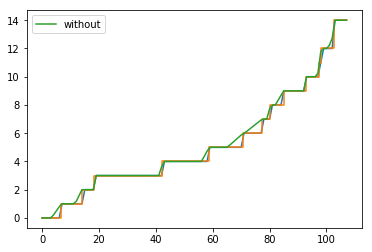

In [70]:
totalT =math.ceil(max(manht))
inter_t = np.arange(0, totalT , 1)
np.interp(inter_t, manht,cuminf)
plt.plot(inter_t, np.interp(inter_t, manht,cuminf))
plt.plot(manht, cuminf)

# plt.xlim([0,10])
# np.interp(inter_t, manht,cuminf)[6]

In [67]:
# max_time = []
# num_inf = []
# for k in range(i):
#     max_time.append(max(Time[k]))
#     num_inf.append(Cum[k][-1])
    
# totalT = math.ceil(max(max_time))
# inter_t = np.arange(0, totalT , 0.5)
# inter_i = []
# inter_e = []
# inter_h = []
# inter_cum = []
# for l in range(Num_sim):
#     inter_i.append(np.interp(inter_t, Time[l], Inf[l], right = 0))
#     inter_e.append(np.interp(inter_t, Time[l], Exp[l], right = 0))
#     inter_h.append(np.interp(inter_t, Time[l], Hos[l], right = 0))
#     inter_cum.append(np.interp(inter_t, Time[l], Cum[l]))

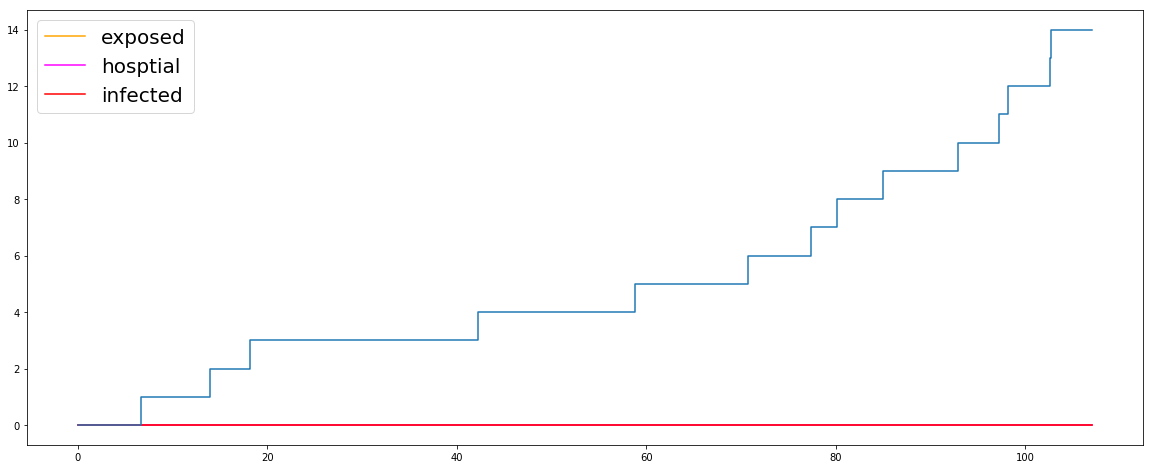

In [54]:
plt.figure(figsize = (20,8))
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hosptial')
plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')

plt.plot(manht, cuminf)
plt.legend(fontsize = 20)



In [ ]:
final = np.zeros(shape = (Num_param,Num_param))
duration = np.zeros(shape = (Num_param,Num_param))

for k in range(Num_param):
    for y in range(Num_param):
        start = time.time()
        B = betas[k]
        E = eps[y]
        Time = []
        Cum = []
        Num_sim = 100
        for i in range(Num_sim):
            Gh_adj = gillespieSEIHR(Input_H, B, μ1, μ2, σ, ω, E, α,pp, γ, capT)
            SEIHRt_adj = Gh_adj[0]
#             cum_inf = []
            manht = []
            for ind, x in enumerate(SEIHRt_adj):
                if ind<len(SEIHRt_adj)-1:
                    manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
#                     cum_inf.append((np.cumsum(np.array(Gh_adj[2]) == 1)[ind], np.cumsum(np.array(Gh_adj[2]) == 1)[ind])) 
            Time.append(np.array(manht).flatten())
            Cum.append(sum(np.array(Gh_adj[2])==1))
#             Cum.append(np.array(cum_inf).flatten())
        total_time = []
#         num_inf = []
        for j in range(Num_sim):
            total_time.append(max(Time[j]))
#             num_inf.append(np)
#         print(np.mean(Cum))
        final[k,y] = np.mean(Cum)
        duration[k,y] = np.mean(total_time)

## Find Tolerance for chosen $\beta$ and $\mu$

Take tol to be 62

In [68]:
β = 0.005
ϵ = 0.0001
α = 1/2
pp = 0.7

In [69]:
M =gillespieSEIHR(parameters[0], β, parameters[1],parameters[2],
                      parameters[3], parameters[4], α,ϵ,pp,  parameters[6])
time = [] #make results of M a step function
cuminf = [] #steps
for ind, x in enumerate(M[0]):
    if ind < len(M[0])-1:
        time.append((M[0][ind], M[0][ind+1]))
        cuminf.append((M[3][ind], M[3][ind]))
time = np.array(time).flatten()
cuminf = np.array(cuminf).flatten()
max_inf = max(cuminf)
max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)


summary_time = summary[0]
#         print(summary_time, max(summary_time[0]), max_time)
summary_cum = summary[1]
if max_time> max(summary_time):
    length1 =  np.arange(max(summary_time), max_time +1, 1)
    summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
    summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
#         print(summary_cum)
if max_time < max(summary_time):
    length2 = np.arange(max_time, max(summary_time)+1, 1)
    time = np.append(time,length2)
    cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
inter_cum = np.interp(inter_t, time,cuminf) #daily steps

#         print(summary_time, summary_cum)
print(np.linalg.norm(summary_cum-inter_cum[summary_time]), β, ϵ, α, pp)

62.24949798994366 0.005 0.0001 0.5 0.7


# Summary Statistics 


In [4]:
#####################################################################################
############################### DATASETS ############################################
#####################################################################################

Data_F04=pd.read_csv("../Case_data/2004_F_cases.csv",sep = ',', header = 0)
Data_T05=pd.read_csv("../Case_data/2005_T_cases.csv",sep = ',', header = 0)
Data_T07=pd.read_csv("../Case_data/2007_T_cases.csv",sep = ',', header = 0)
Data_F10=pd.read_csv("../Case_data/2010_faridpur_cases.csv",sep = ',', header = 0)
Data_F11=pd.read_csv("../Case_data/2011_Faridpur_cases.csv",sep = ',', header = 0)
Data_L11=pd.read_csv("../Case_data/2011_Lalmonirhat_cases.csv",sep = ',', header = 0)
Data_R11=pd.read_csv("../Case_data/2011_Rangpur_cases.csv",sep = ',', header = 0)
Data_J12=pd.read_csv("../Case_data/2012_Joypurhat_cases.csv",sep = ',', header = 0)
Data_R12=pd.read_csv("../Case_data/2012_rajshiahi_cases.csv",sep = ',', header = 0)
Data_R14=pd.read_csv("../Case_data/2014_rangpur_cases.csv",sep = ',', header = 0)

############################# Spacing ##############################################
date_format = "%d/%m/%y"


def Spacing(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days) 
    return record
# print(Data_L11)
Rec_F04=Spacing(Data_F04)
Rec_T05=Spacing(Data_T05)
Rec_T07=Spacing(Data_T07)
Rec_F10 = Spacing(Data_F10)
Rec_F11=Spacing(Data_F11)
Rec_L11=Spacing(Data_L11)
Rec_R11=Spacing(Data_R11)
Rec_J12=Spacing(Data_J12)
Rec_R12=Spacing(Data_R12)
Rec_R14=Spacing(Data_R14)
names = ['2004 Faridpur', '2005 Tangail', '2007 Thakurgaon', '2010 Faridpur',
         '2011 Faridpur', '2011 Lalmonirhat', '2011 Rangpur', '2012 Joypurhat', '2012 Rajshiahi', '2014 Rangpur' ]
records = [Rec_F04, Rec_T05, Rec_T07,Rec_F10, Rec_F11, Rec_L11, Rec_R11, Rec_J12, Rec_R12, Rec_R14]
data = [Data_F04, Data_T05, Data_T07, Data_F10, Data_F11, Data_L11, Data_R11, Data_J12, Data_R12, Data_R14]

# ABC

Code requires:

summary statistic -- a np.array where the first column is 

In [89]:
def ABC(dist, sumstat, model_param, tol, TT, N,prior, δ):
    t = 0 
    θ = []
    β1, ɛ1, α1, p1 = prior
#     print(np.array([β1, ɛ1, p1 ]))
    θ = [np.array([β1, ɛ1, α1, p1]).T]
    print(θ[0][:,0])
    t = 1
    θ_t = []
    error = []
    while t< TT:
        r_β = np.random.randint(0, N-1)
        r_ϵ = np.random.randint(0,N-1)
        r_α = np.random.randint(0,N-1)
        r_p = np.random.randint(0,N-1)
        δ = np.random.uniform(0, 1e-3)
        βt, ɛt, αt, pt = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_p] +δ, θ[t-1][:,3][r_p] +δ
        
        M =gillespieSEIHR(model_param[0], βt, model_param[1],model_param[2],
                          model_param[3], model_param[4], αt,ɛt,pt,  model_param[6])
        time = [] #make results of M a step function
        cuminf = [] #steps
        for ind, x in enumerate(M[0]):
            if ind < len(M[0])-1:
                time.append((M[0][ind], M[0][ind+1]))
                cuminf.append((M[3][ind], M[3][ind]))
        time = np.array(time).flatten()
        cuminf = np.array(cuminf).flatten()
        max_inf = max(cuminf)
        max_time = math.ceil(max(time))
    #     print(max_inf, max_time, βt, ɛt)


        summary_time = summary[0]
    #         print(summary_time, max(summary_time[0]), max_time)
        summary_cum = summary[1]
        if max_time> max(summary_time):
            length1 =  np.arange(max(summary_time), max_time +1, 1)
            summary_time = np.append(summary_time, length1)
    #         print(summary_time, len( length1))
            summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
    #         print(summary_cum)
        if max_time < max(summary_time):
            length2 = np.arange(max_time, max(summary_time)+1, 1)
            time = np.append(time,length2)
            cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

        inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
        inter_cum = np.interp(inter_t, time,cuminf) #daily steps

    #         print(summary_time, summary_cum)
        print(np.linalg.norm(summary_cum-inter_cum[summary_time]), βt, ɛt, pt)
        if np.linalg.norm(summary_cum-inter_cum[summary_time]) <tol:
            θ_t.append(np.array([βt, ɛt, αt, pt]))
            print(len(θ_t))
    #             θ_t = np.array(θ_t)
    #             print(θ_t)
            error.append(np.linalg.norm(summary_cum-inter_cum[summary_time]))
        if len(θ_t) == N:
            tol = np.median(error)
            θ_t = np.array(θ_t)
            print(θ_t)
            θ.append(θ_t)
            t +=1 
            θ_t = []
            error = []
            
    return θ

In [172]:
[int(a-Rec_F04[0]) for a in Rec_F04]

[0, 14, 16, 19, 26, 29, 34, 35, 36, 39, 40, 41, 42, 43, 45, 53, 54, 55, 56, 57]

In [173]:
Input_H = [1500, 1, 0 ,0, 0]
parameters = [Input_H, μ1, μ2, σ, ω, α, capT] #initialconditions, mu1, mu2, sigma, omega, alpha, maxtime
summary = np.array([[int(a-Rec_F04[0]) for a in Rec_F04], Data_F04['CumsumInf'].values])
# ABC(np.linalg.norm, summary, parameters, 90, 10, 50, [np.random.uniform(0,0.1, 50), np.random.uniform(0,0.001, 50), np.random.uniform(0,1, 50), np.random.uniform(0,1, 50)], 1e-4)

In [184]:
summary

array([[ 0, 14, 16, 19, 26, 29, 34, 35, 36, 39, 40, 41, 42, 43, 45, 53,
        54, 55, 56, 57],
       [ 1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 14, 17, 26, 27, 28, 31,
        33, 34, 35, 36]])

In [175]:
N = 100
tol = 91
t = 0 
θ = []
β1, ɛ1, α1,p1 =  [np.random.uniform(0,0.1, N), np.random.uniform(0,0.001, N),np.random.uniform(0,1, N), np.random.uniform(0,1, N)]
#     print(np.array([β1, ɛ1, p1 ]))
θ = [np.array([β1, ɛ1, α1, p1]).T]
# print(θ[0][:,0])
t = 1
θ_t = []
tols = []
tols.append(tol)
error = []
while t< 6:
    r_β = np.random.randint(0, N-1)
    r_ϵ = np.random.randint(0,N-1)
    r_α = np.random.randint(0,N-1)
    r_p = np.random.randint(0,N-1)
    δ = np.random.uniform(0, 1e-3)
    βt, ɛt,αt, pt = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_α] + δ, θ[t-1][:,3][r_p] +δ

    M =gillespieSEIHR(parameters[0], βt, parameters[1],parameters[2],
                      parameters[3], parameters[4], αt,ɛt,pt,  parameters[6])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = summary[0]
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = summary[1]
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 1)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    
#         print(summary_time, summary_cum)
#     print(np.linalg.norm(summary_cum-inter_cum[summary_time]), βt, ɛt, pt)
    if np.linalg.norm(summary_cum-inter_cum[summary_time]) <tol:
        θ_t.append(np.array([βt, ɛt, αt, pt]))
        print(len(θ_t), t, tol)
#             θ_t = np.array(θ_t)
#             print(θ_t)
        error.append(np.linalg.norm(summary_cum-inter_cum[summary_time]))
    if len(θ_t) == N:
        tol = np.median(error)
        tols.append(tol)
        θ_t = np.array(θ_t)
        print(θ_t)
        θ.append(θ_t)
        t +=1 
        θ_t = []
        error = []

1 1 91
2 1 91
3 1 91
4 1 91
5 1 91
6 1 91
7 1 91
8 1 91
9 1 91
10 1 91
11 1 91
12 1 91
13 1 91
14 1 91
15 1 91
16 1 91
17 1 91
18 1 91
19 1 91
20 1 91
21 1 91
22 1 91
23 1 91
24 1 91
25 1 91
26 1 91
27 1 91
28 1 91
29 1 91
30 1 91
31 1 91
32 1 91
33 1 91
34 1 91
35 1 91
36 1 91
37 1 91
38 1 91
39 1 91
40 1 91
41 1 91
42 1 91
43 1 91
44 1 91
45 1 91
46 1 91
47 1 91
48 1 91
49 1 91
50 1 91
51 1 91
52 1 91
53 1 91
54 1 91
55 1 91
56 1 91
57 1 91
58 1 91
59 1 91
60 1 91
61 1 91
62 1 91
63 1 91
64 1 91
65 1 91
66 1 91
67 1 91
68 1 91
69 1 91
70 1 91
71 1 91
72 1 91
73 1 91
74 1 91
75 1 91
76 1 91
77 1 91
78 1 91
79 1 91
80 1 91
81 1 91
82 1 91
83 1 91
84 1 91
85 1 91
86 1 91
87 1 91
88 1 91
89 1 91
90 1 91
91 1 91
92 1 91
93 1 91
94 1 91
95 1 91
96 1 91
97 1 91
98 1 91
99 1 91
100 1 91
[[4.62261725e-02 1.25613242e-04 5.13305778e-01 2.53064810e-01]
 [9.58585325e-02 4.89076403e-05 5.02699139e-01 4.00579560e-01]
 [2.08803078e-02 2.53800774e-04 6.38559616e-01 9.15595001e-01]
 [7.66328861e-02 8.

50 2 90.69729874698585
51 2 90.69729874698585
52 2 90.69729874698585
53 2 90.69729874698585
54 2 90.69729874698585
55 2 90.69729874698585
56 2 90.69729874698585
57 2 90.69729874698585
58 2 90.69729874698585
59 2 90.69729874698585
60 2 90.69729874698585
61 2 90.69729874698585
62 2 90.69729874698585
63 2 90.69729874698585
64 2 90.69729874698585
65 2 90.69729874698585
66 2 90.69729874698585
67 2 90.69729874698585
68 2 90.69729874698585
69 2 90.69729874698585
70 2 90.69729874698585
71 2 90.69729874698585
72 2 90.69729874698585
73 2 90.69729874698585
74 2 90.69729874698585
75 2 90.69729874698585
76 2 90.69729874698585
77 2 90.69729874698585
78 2 90.69729874698585
79 2 90.69729874698585
80 2 90.69729874698585
81 2 90.69729874698585
82 2 90.69729874698585
83 2 90.69729874698585
84 2 90.69729874698585
85 2 90.69729874698585
86 2 90.69729874698585
87 2 90.69729874698585
88 2 90.69729874698585
89 2 90.69729874698585
90 2 90.69729874698585
91 2 90.69729874698585
92 2 90.69729874698585
93 2 90.697

33 3 77.19779619790685
34 3 77.19779619790685
35 3 77.19779619790685
36 3 77.19779619790685
37 3 77.19779619790685
38 3 77.19779619790685
39 3 77.19779619790685
40 3 77.19779619790685
41 3 77.19779619790685
42 3 77.19779619790685
43 3 77.19779619790685
44 3 77.19779619790685
45 3 77.19779619790685
46 3 77.19779619790685
47 3 77.19779619790685
48 3 77.19779619790685
49 3 77.19779619790685
50 3 77.19779619790685
51 3 77.19779619790685
52 3 77.19779619790685
53 3 77.19779619790685
54 3 77.19779619790685
55 3 77.19779619790685
56 3 77.19779619790685
57 3 77.19779619790685
58 3 77.19779619790685
59 3 77.19779619790685
60 3 77.19779619790685
61 3 77.19779619790685
62 3 77.19779619790685
63 3 77.19779619790685
64 3 77.19779619790685
65 3 77.19779619790685
66 3 77.19779619790685
67 3 77.19779619790685
68 3 77.19779619790685
69 3 77.19779619790685
70 3 77.19779619790685
71 3 77.19779619790685
72 3 77.19779619790685
73 3 77.19779619790685
74 3 77.19779619790685
75 3 77.19779619790685
76 3 77.197

16 4 59.86588373838895
17 4 59.86588373838895
18 4 59.86588373838895
19 4 59.86588373838895
20 4 59.86588373838895
21 4 59.86588373838895
22 4 59.86588373838895
23 4 59.86588373838895
24 4 59.86588373838895
25 4 59.86588373838895
26 4 59.86588373838895
27 4 59.86588373838895
28 4 59.86588373838895
29 4 59.86588373838895
30 4 59.86588373838895
31 4 59.86588373838895
32 4 59.86588373838895
33 4 59.86588373838895
34 4 59.86588373838895
35 4 59.86588373838895
36 4 59.86588373838895
37 4 59.86588373838895
38 4 59.86588373838895
39 4 59.86588373838895
40 4 59.86588373838895
41 4 59.86588373838895
42 4 59.86588373838895
43 4 59.86588373838895
44 4 59.86588373838895
45 4 59.86588373838895
46 4 59.86588373838895
47 4 59.86588373838895
48 4 59.86588373838895
49 4 59.86588373838895
50 4 59.86588373838895
51 4 59.86588373838895
52 4 59.86588373838895
53 4 59.86588373838895
54 4 59.86588373838895
55 4 59.86588373838895
56 4 59.86588373838895
57 4 59.86588373838895
58 4 59.86588373838895
59 4 59.865

1 5 49.45659638086555
2 5 49.45659638086555
3 5 49.45659638086555
4 5 49.45659638086555
5 5 49.45659638086555
6 5 49.45659638086555
7 5 49.45659638086555
8 5 49.45659638086555
9 5 49.45659638086555
10 5 49.45659638086555
11 5 49.45659638086555
12 5 49.45659638086555
13 5 49.45659638086555
14 5 49.45659638086555
15 5 49.45659638086555
16 5 49.45659638086555
17 5 49.45659638086555
18 5 49.45659638086555
19 5 49.45659638086555
20 5 49.45659638086555
21 5 49.45659638086555
22 5 49.45659638086555
23 5 49.45659638086555
24 5 49.45659638086555
25 5 49.45659638086555
26 5 49.45659638086555
27 5 49.45659638086555
28 5 49.45659638086555
29 5 49.45659638086555
30 5 49.45659638086555
31 5 49.45659638086555
32 5 49.45659638086555
33 5 49.45659638086555
34 5 49.45659638086555
35 5 49.45659638086555
36 5 49.45659638086555
37 5 49.45659638086555
38 5 49.45659638086555
39 5 49.45659638086555
40 5 49.45659638086555
41 5 49.45659638086555
42 5 49.45659638086555
43 5 49.45659638086555
44 5 49.456596380865

In [182]:
np.save('tols1.npy', tols)

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


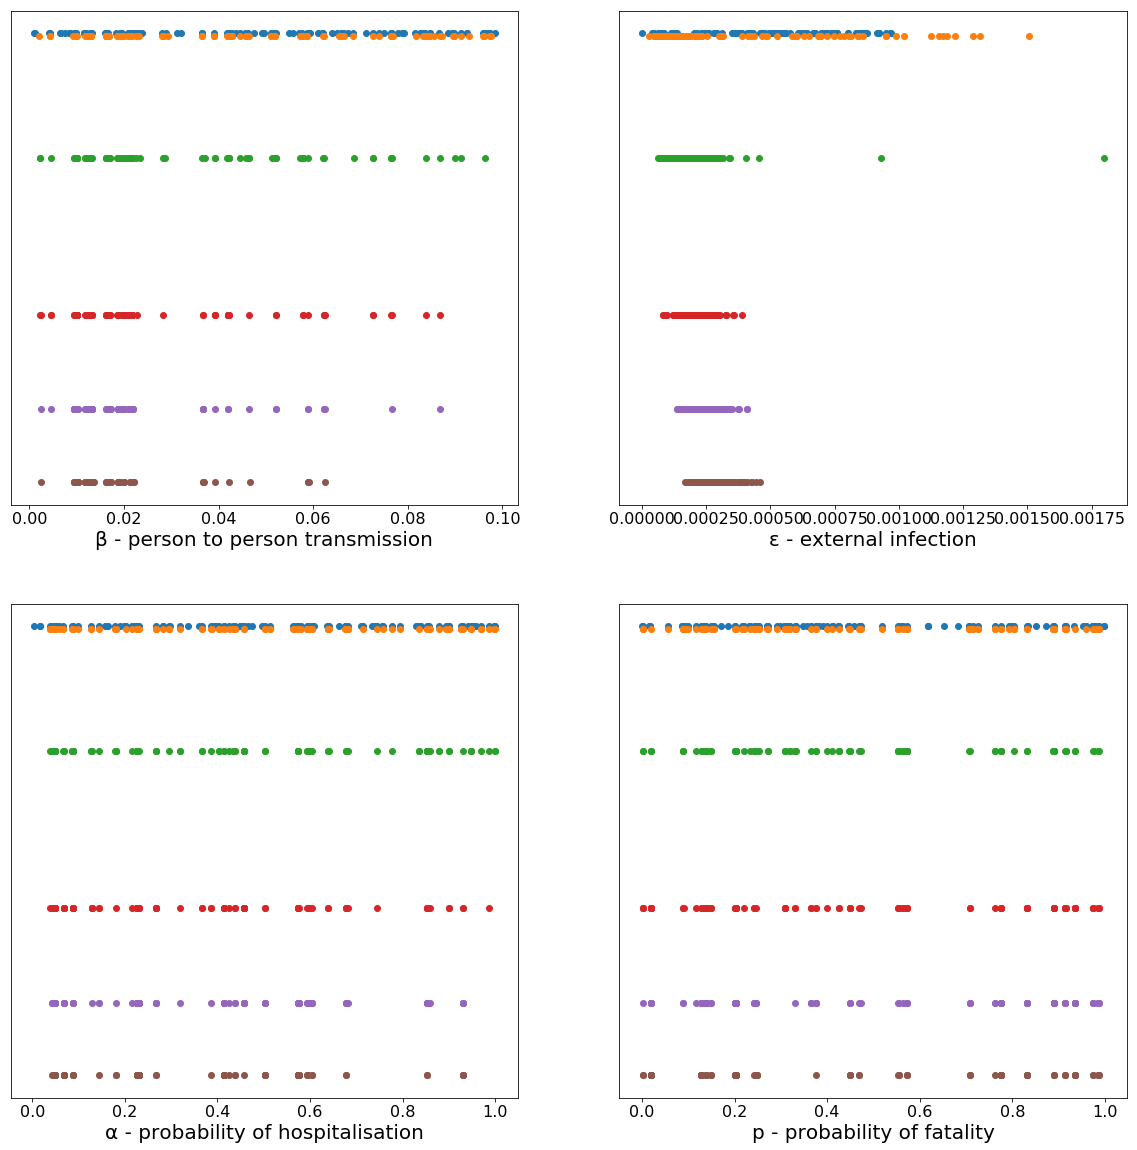

In [183]:
# np.save('theta1.npy', θ)
plt.figure(figsize = (20,20))
tol = 6
for i in range(6):
    plt.subplot(2,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(100), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(2,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(100), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(2,2,3)
    plt.plot(θ[i][:,2], tols[i]*np.ones(100), 'o' )
    plt.xlabel('α - probability of hospitalisation', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(2,2,4)
    plt.plot(θ[i][:,3], tols[i]*np.ones(100), 'o' )
    plt.xlabel('p - probability of fatality', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)

    
    tol -=1

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'ɛ')

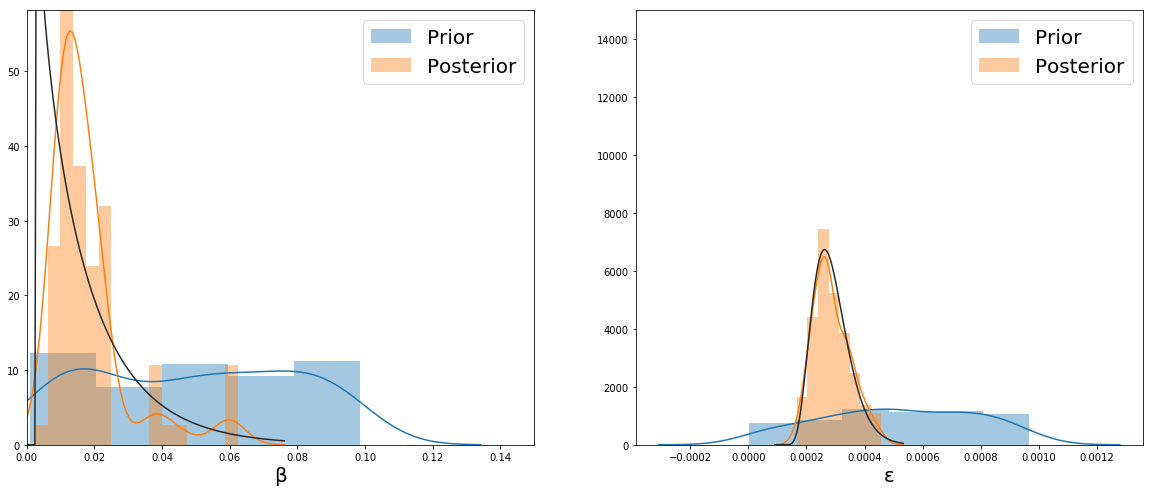

In [180]:
# sns.kdeplot(θ[5][:,1])
from scipy import stats
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.legend(fontsize = 20)
# plt.ylim([0, 100])
plt.xlim([0,0.15])
plt.xlabel('β', fontsize = 20)

plt.subplot(1,2,2)
sns.distplot(θ[0][:,1], kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,1], kde=True,  fit=stats.gamma,  norm_hist=False, label = 'Posterior')
plt.legend(fontsize = 20)
plt.ylim([0, 15000])

plt.xlabel('ɛ', fontsize = 20)

In [128]:
# len(θ[5][:,1])